# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)


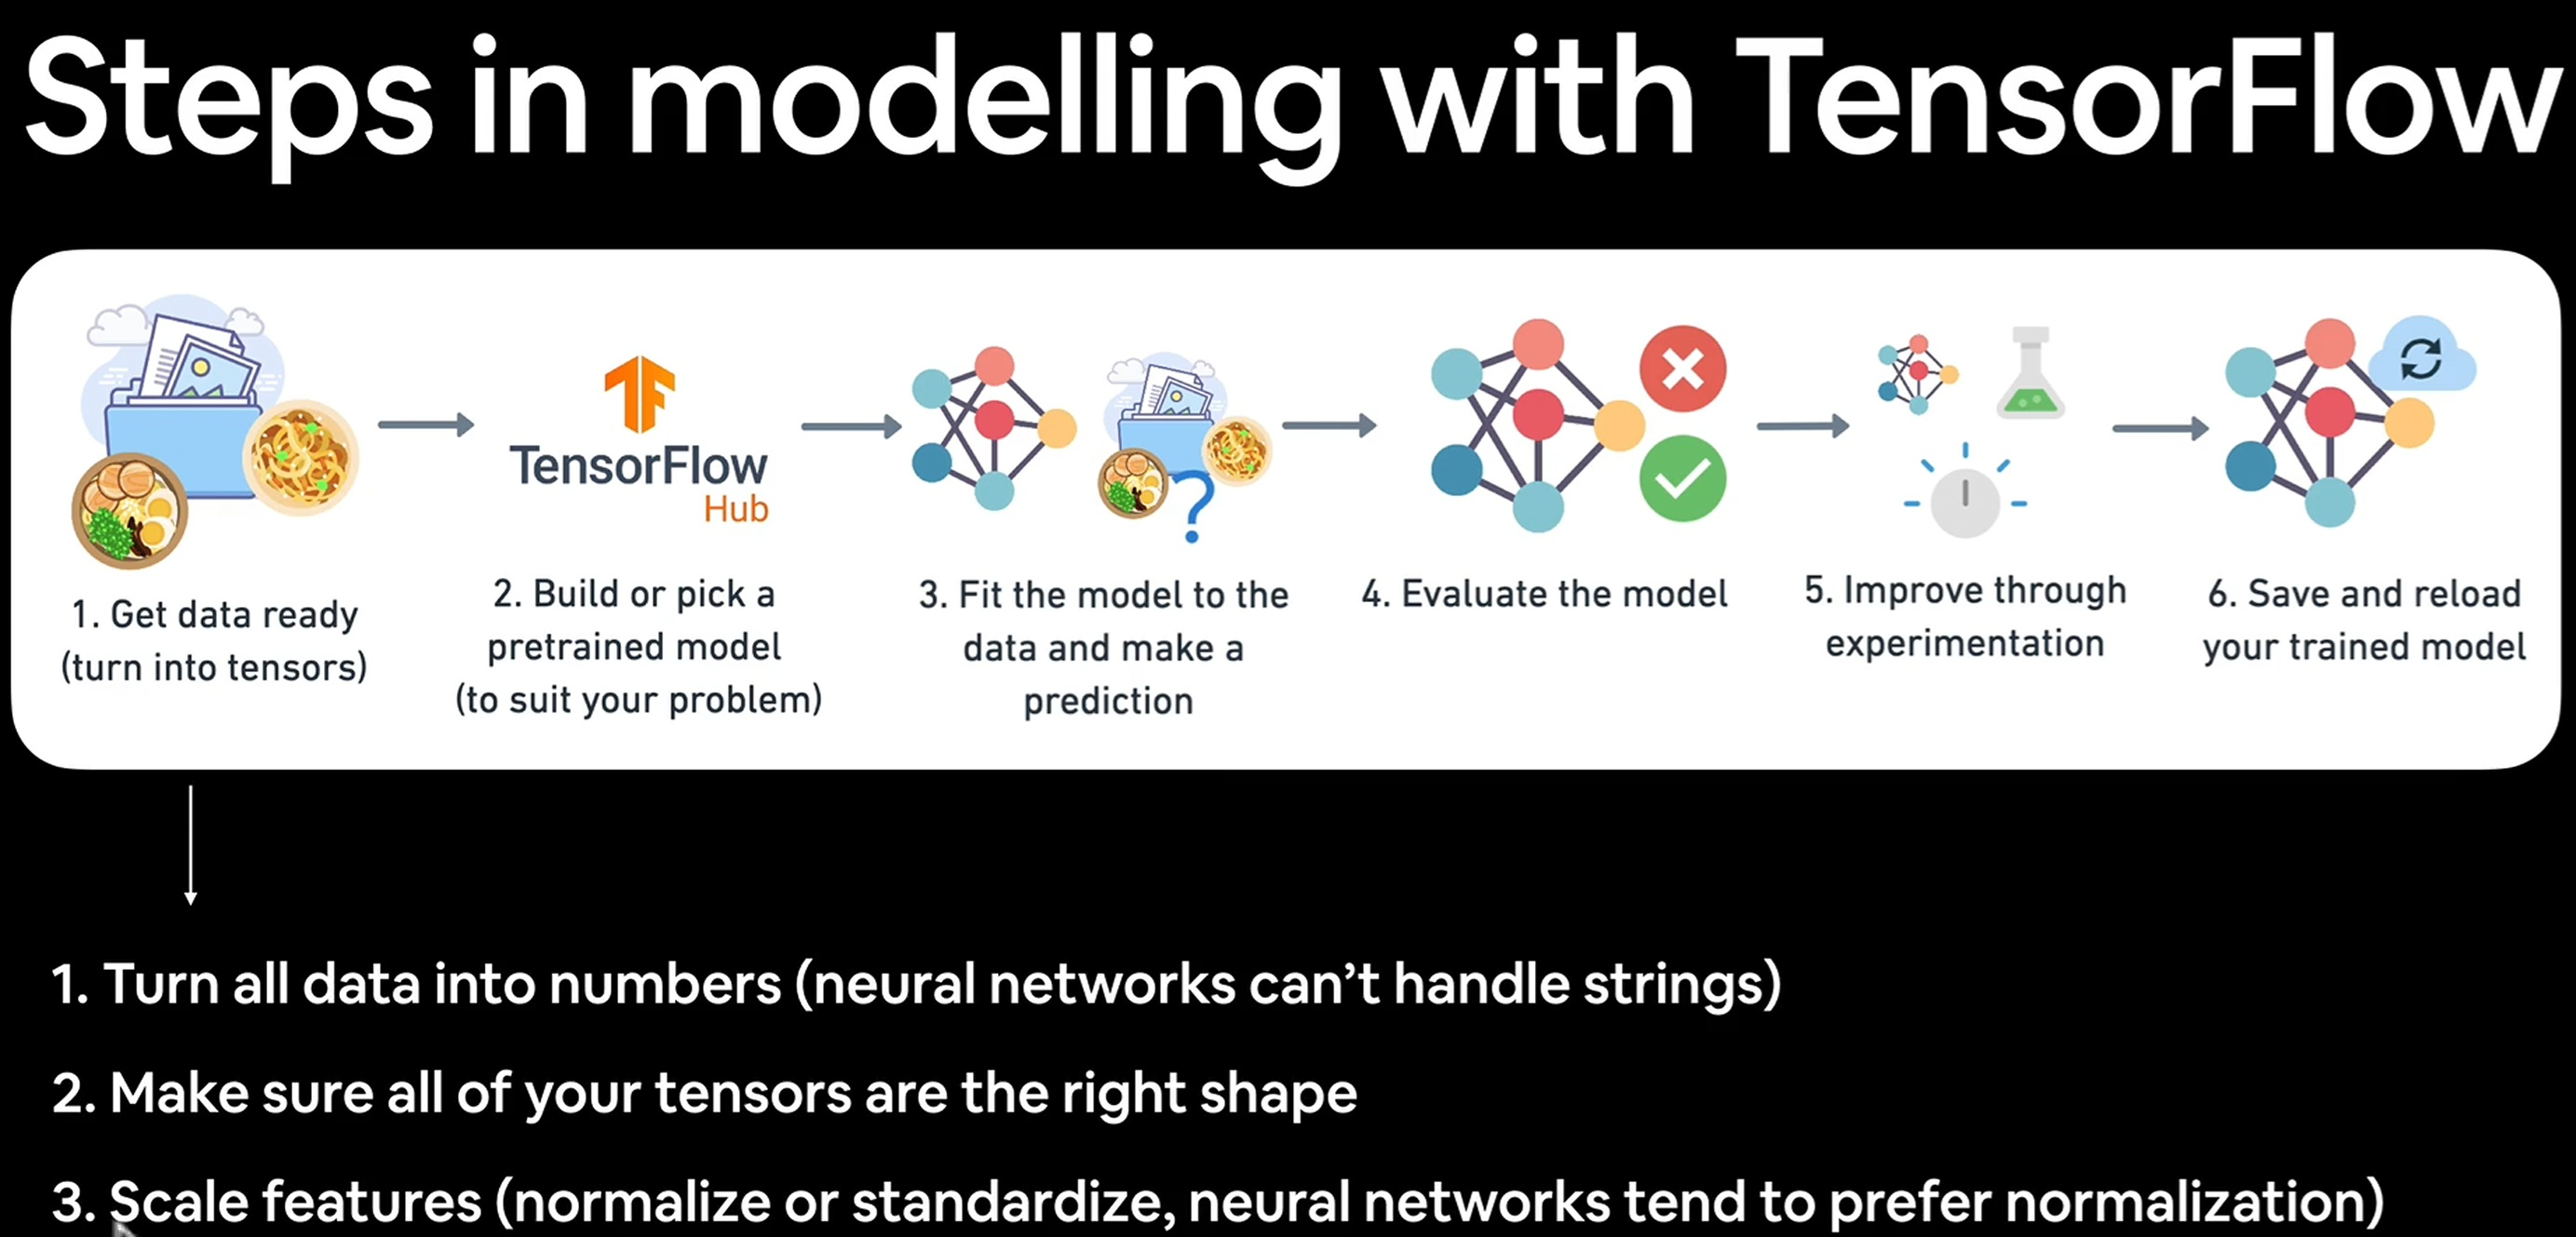

## Typical architecture of a classification neural network

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

Table 1: Typical architecture of a classification network. Source: Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)


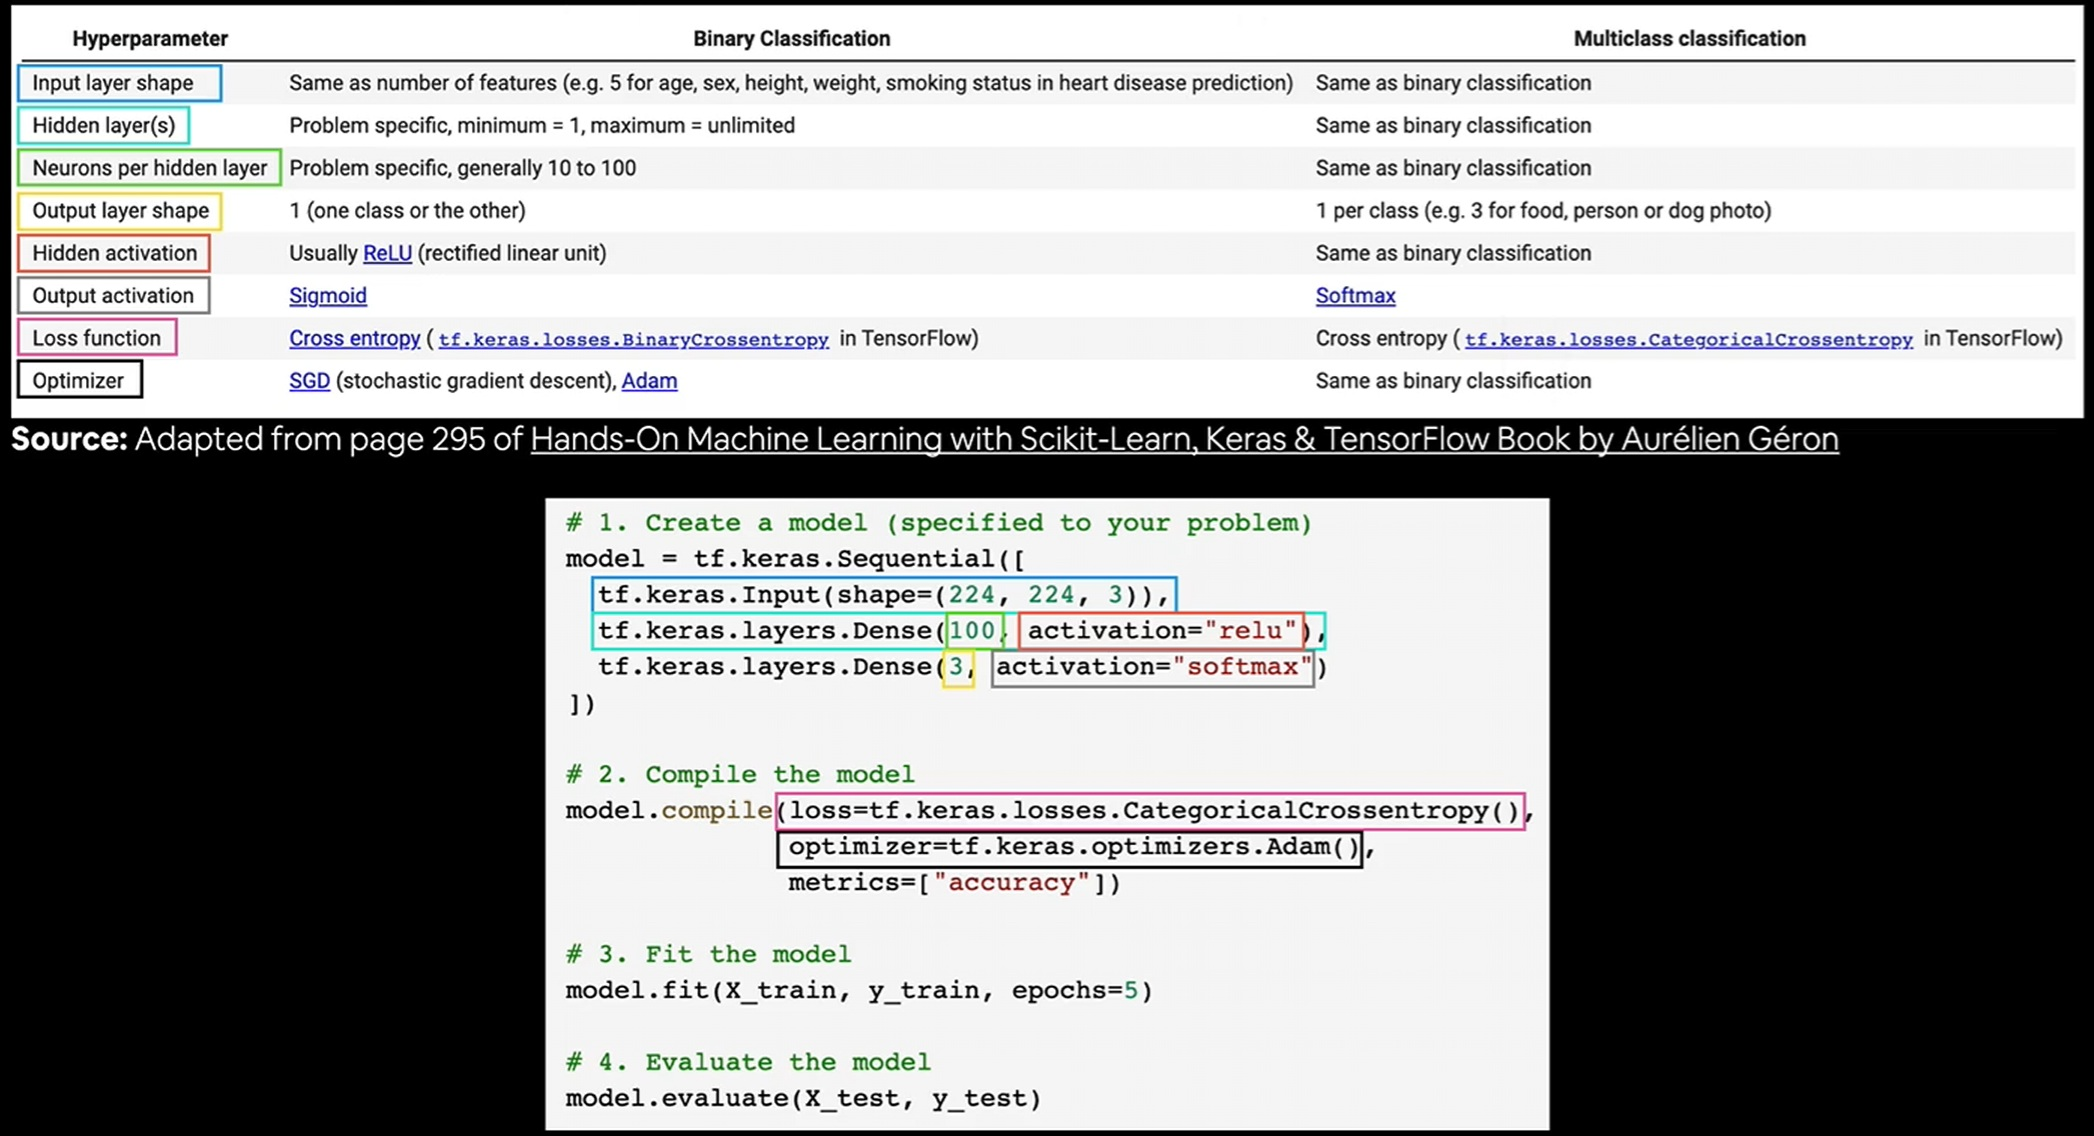

## Creating data to view and fit

### Creating sample circle data

In [1]:
from sklearn.datasets import make_circles

# Make 1000 examples
n = 1000

# Create circles
X, y = make_circles(n_samples=n, noise=0.05, random_state=42)

In [2]:
# Check out the features
print(X[:5])

[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]


In [3]:
# Check out the labels
print(y[:5])

[1 1 1 1 0]


### Visualize our circle data

Our data is a littlt bit hard to understand, let's visualize it!

In [4]:
import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


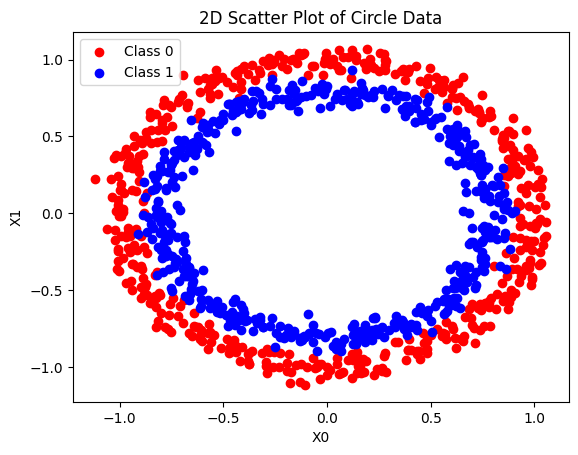

"\nThe data is not linearly separable, meaning we can't draw a straight line to separate the two classes.\nThis is where neural networks come in handy.\n\nLabel 0: Points that are inside the inner circle.\nLabel 1: Points that are outside the inner circle but within the outer circle.\n"

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(circles[circles['label'] == 0]['X0'], circles[circles['label'] == 0]['X1'], color='red', label='Class 0')
plt.scatter(circles[circles['label'] == 1]['X0'], circles[circles['label'] == 1]['X1'], color='blue', label='Class 1')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()
plt.title('2D Scatter Plot of Circle Data')
plt.show()

# * Note: 
"""
The data is not linearly separable, meaning we can't draw a straight line to separate the two classes.
This is where neural networks come in handy.

Label 0: Points that are inside the inner circle.
Label 1: Points that are outside the inner circle but within the outer circle.
"""


In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# How many samples we're working with
len(X), len(y)

(1000, 1000)

In [8]:
# View the first example of features and labels
X[0], y[0]

(array([0.74220688, 0.24668576]), 1)

## Build our classification models

In [9]:
import tensorflow as tf

2024-11-14 08:19:16.178360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 08:19:21.494993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 08:19:23.305559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 08:19:23.774629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 08:19:27.241089: I tensorflow/core/platform/cpu_feature_guar

In [10]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X, y, epochs=10)

I0000 00:00:1731543616.302885    2113 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731543621.115507    2113 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731543621.115585    2113 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731543621.129625    2113 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731543621.129687    2113 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/10


I0000 00:00:1731543622.539333   16691 service.cc:146] XLA service 0x7f418c016da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731543622.539408   16691 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-11-14 08:20:23.354629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 08:20:24.843103: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4717 - loss: 4.6246 

I0000 00:00:1731543626.461669   16691 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4716 - loss: 4.6113
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5062 - loss: 3.5080 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4458 - loss: 0.7401 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4781 - loss: 0.6972 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5054 - loss: 0.6934 
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5078 - loss: 0.6934 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5014 - loss: 0.6938 
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4842 - loss: 0.6941 
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4592 - loss: 0.6944 
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4458 - loss: 0.6946


In [11]:
model_1.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4547 - loss: 0.6929


[0.6932639479637146, 0.4560000002384186]

## Improving our model

Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [12]:
# Try to improve our model by training for longer
model_1.fit(X, y, epochs=200, verbose=0)

In [13]:
model_1.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4875 - loss: 0.6928


[0.693287193775177, 0.4729999899864197]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [14]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API but with an extra layer
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1), # add another layer
    tf.keras.layers.Dense(1),
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0)


# Evaluate the model
model_2.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4955 - loss: 0.6934


[0.6932072639465332, 0.5]

Still not even as good as guessing (~50% accuracy)

Let's remind ourselves of a couple more ways we can use to improve our models.

### Adding layers and increase the number of hidden units

In [15]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API but with an extra layer
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100), # add 100 dense neurons
    tf.keras.layers.Dense(10), # add another layer with 10 neurons
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_3.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5067 - loss: 0.6917


[0.6943462491035461, 0.48399999737739563]

Performance is still really poor.

Let's make some visualizations to see what's happening.

Note: When model is performing strangely or there's something going on with the data we are not quite sure of, remember to **visualize visualize visualize**. Inspect your data, inspect your model, inspect your model's predictions.

### Visualize the model's predictions

We are going to create a function plot_decision_boundary() which:
- Takes in a trained model, features(`X`) and labels(`y`).
- Create a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
- Makes predictions across the meshgrid.
- Plots the predictions as well as a line between the fifferent zones (where each unique class falls).

In [16]:
import numpy as np

def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary created by a model predicting on X.
    This function has been adapted from two phenomenal resources:
    1. CS231n - https://cs231n.github.io/neural-networks-case-study/
    2. Made with ML basics - https://github.com/GokuMohandas/Made-With-ML
    """

    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

    # Make predictions using the trained model
    y_pred = model.predict(x_in)

    # Check for multi-class
    if model.output_shape[-1] > 1: # if there's more than 1 output, we'll assume it's multi-class
        print("doing multiclass classification...")
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape) 
    else:
        print("doing binary classification...")
        y_pred = np.round(y_pred).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
doing binary classification...


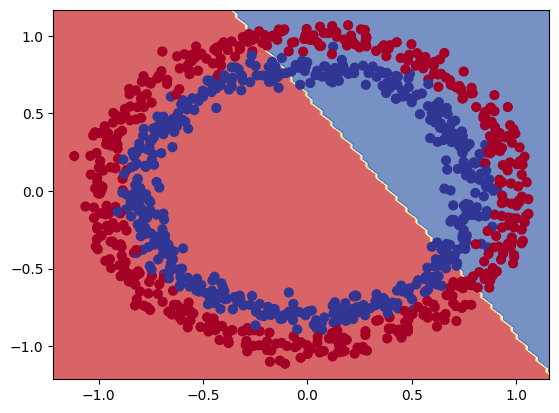

In [17]:
# Check out the predictions our model is making
plot_decision_boundary(model_3, X, y)

### Testing our model in regression problem

In [18]:
# Create some regression data
X_regression = tf.range(0, 1000, 5)
y_regression = tf.range(100, 1100, 5)

# Split our regression data into training and test sets
split_size = int(0.8 * len(X_regression)) # 80% train, 20% test
X_reg_train, y_reg_train = X_regression[:split_size], y_regression[:split_size]
X_reg_test, y_reg_test = X_regression[split_size:], y_regression[split_size:]

# Check the lengths
len(X_reg_train), len(X_reg_test), len(y_reg_train), len(y_reg_test)

(160, 40, 160, 40)

In [19]:
# Recreate the model for regression problem

# Set random seed
tf.random.set_seed(42)

# 1. Create the model with same architecture as model_3
model_reg = tf.keras.Sequential([
    tf.keras.layers.Dense(100), # add 100 dense neurons
    tf.keras.layers.Dense(10), # add another layer with 10 neurons
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_reg.compile(loss=tf.keras.losses.mae, # change the loss function to mean absolute error
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) # change the metrics to mean absolute error

# 3. Fit the model
model_reg.fit(tf.expand_dims(X_reg_train, axis=1), y_reg_train, epochs=100, verbose=0)

# Evaluate the model
model_reg.evaluate(X_regression, y_regression)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 50.5004 - mae: 50.5004


[40.96192932128906, 40.96192932128906]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


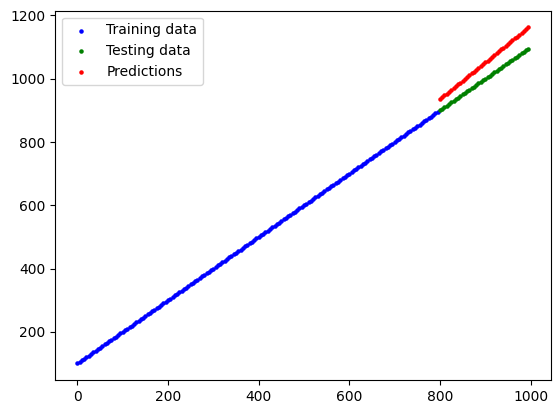

In [20]:
# Make predictions with the regression model
y_reg_preds = model_reg.predict(tf.expand_dims(X_reg_test, axis=1))

# Plot the model's predictions against the regression data
plt.scatter(X_reg_train, y_reg_train, color='b', label='Training data', s=5)
plt.scatter(X_reg_test, y_reg_test, color='g', label='Testing data', s=5)
plt.scatter(X_reg_test, y_reg_preds, color='r', label='Predictions', s=5)
plt.legend()

# The predictions looks better than complete guessing, so this means our model must be learning something.
# There must be something we are missing our on for our classification model.

### The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and blue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)

In [21]:
# Let's recreate the basic setting in TensorFlow Playground
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_4.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_4.evaluate(X, y)

# Our model performs like guessing in the basic setting.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5211 - loss: 0.6931


[0.7014836072921753, 0.4959999918937683]

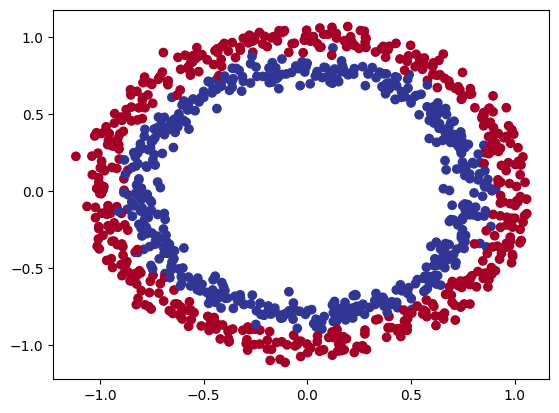

In [22]:
# Check out our data again
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classification...


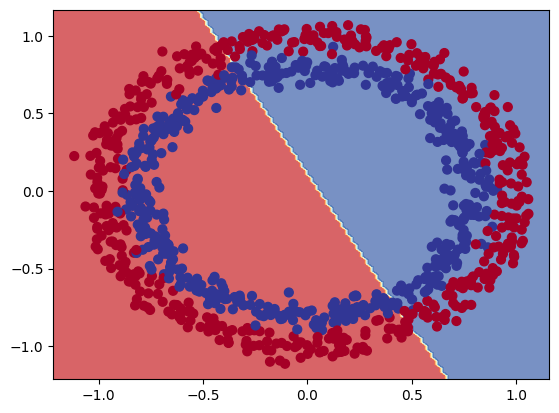

In [23]:
# And let's see how our model is making predictions on it.
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

### Trying `ReLU` activation for non-linear data

ReLU: Rectified Linear Unit

In [24]:
# Set random seed
tf.random.set_seed(42)

# Create the model with ReLU activation
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # change the activation function to ReLU
    tf.keras.layers.Dense(1) 
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_5.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_5.evaluate(X, y)

# Still worse than guessing, let try to add more layers

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5007 - loss: 0.6930


[0.6931557655334473, 0.4869999885559082]

In [25]:
# Add more layers for our ReLU model
# Set random seed
tf.random.set_seed(42)

# Create the model with ReLU activation
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # add more neurons and layers
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1) 
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_6.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_6.evaluate(X, y)

# Much better! Our model is learning something now.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6895 - loss: 0.6253


[0.6282731890678406, 0.6759999990463257]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classification...


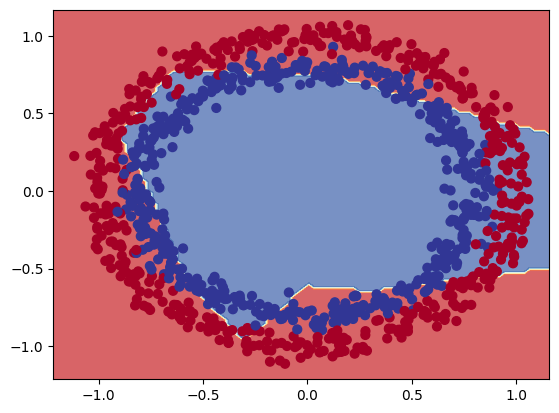

In [26]:
# Checkout the decision boundary
plot_decision_boundary(model_6, X, y)

# Looks like we still have room for improvement

### Adding Sigmoid activation output layer and longer training

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the [Sigmoid activation function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [27]:
# Set random seed
tf.random.set_seed(42)

# Create the model with ReLU activation and sigmoid output
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # change the output activation to sigmoid
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_7.fit(X, y, epochs=200, verbose=0) # train for longer

# Evaluate the model
model_7.evaluate(X, y)

# It reach over 95% accuracy, which is pretty good.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9621 - loss: 0.1222


[0.12304656952619553, 0.9620000123977661]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classification...


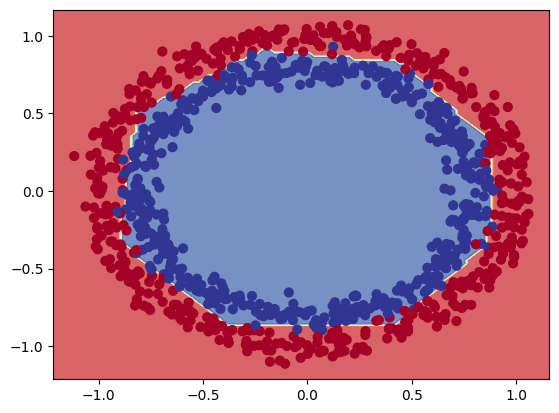

In [28]:
# Checkout the decision boundary
plot_decision_boundary(model_7, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

We've been using a linear function or a non-linear function the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

## Experimenting Linear and Non-Linear with toy tensors

In [29]:
# Create a toy tensor (similar to the data we have been working with)
toy_tensor = tf.cast(tf.range(-10, 10), tf.float32)
toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

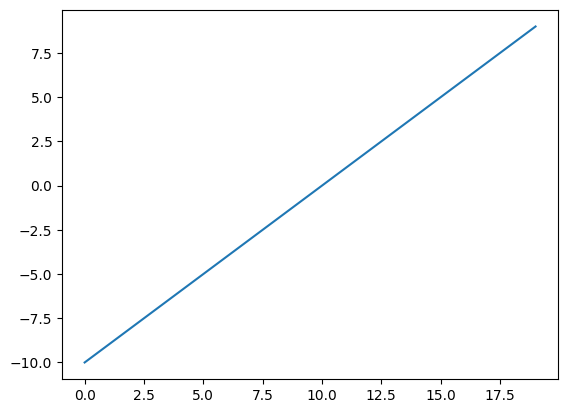

In [30]:
# Visualize the toy tensor
plt.plot(toy_tensor)

A straight (linear) line!

Nice, now let's recreate the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) and see what it does to our data. You can also find a pre-built sigmoid function at [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

In [31]:
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

sigmoid_toy_tensor = sigmoid(toy_tensor)
sigmoid_toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397868e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726230e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105854e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

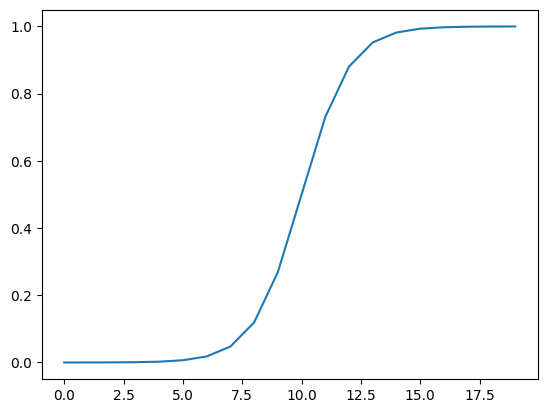

In [32]:
# Plot the toy tensor transformed by the sigmoid function
plt.plot(sigmoid_toy_tensor)

A non-straight (non-linear) line!

Okay, how about the [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.) (ReLU turns all negatives to 0 and positive numbers stay the same)?

In [33]:
def relu(x):
    return tf.maximum(0, x)

relu_toy_tensor = relu(toy_tensor)
relu_toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

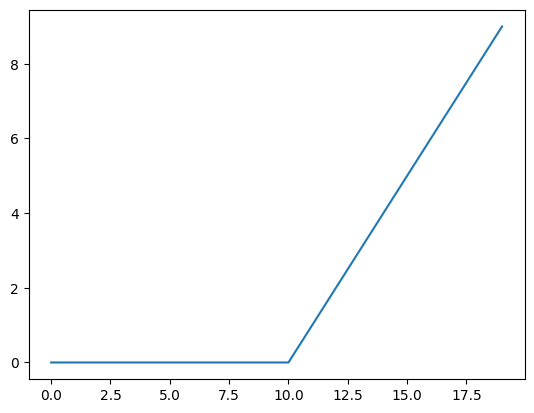

In [34]:
# Plot the toy tensor transformed by the ReLU function
plt.plot(relu_toy_tensor)

Another non-straight line!

Well, how about TensorFlow's [linear activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)?

In [35]:
linear_toy_tensor = tf.keras.activations.linear(toy_tensor)
linear_toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

In [36]:
# The linear activation function doesn't change the input tensor
toy_tensor == linear_toy_tensor

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

Okay, so it makes sense now the model doesn't really learn anything when using only linear activation functions, because the linear activation function doesn't change our input data in anyway.

Where as, with our non-linear functions, our data gets manipulated. A neural network uses these kind of transformations at a large scale to figure draw patterns between its inputs and outputs.

> 📖  **Resource:** For more on activation functions, check out the [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#) on them.

## Evaluating and improving our classification model

If you answered the question above, you might've picked up what we've been doing wrong.

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

Let's do it.

In [37]:
# What's the size of the dataset?
len(X)

1000

In [38]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [39]:
# Recreate a model to fit on the training data and evaluate on the testing data

# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # changed the learning rate from 0.001 to 0.01
                metrics=['accuracy'])

# Fit the model
model_8_fit_history = model_8.fit(X_train, y_train, epochs=25) # testing with only 25 steps for our new model

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5345 - loss: 0.6850
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6129 - loss: 0.6746
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5953 - loss: 0.6680
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5970 - loss: 0.6615
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6098 - loss: 0.6557
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6136 - loss: 0.6500
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6164 - loss: 0.6441 
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6197 - loss: 0.6363
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6340 - loss: 0.6282 
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6608 - loss: 0.6194 
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6606 - loss: 0.6098 
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6605 

In [40]:
# Evaluate the model
model_7.evaluate(X, y)

# The performance was great (over 90% accuracy) for only 25 epochs

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9621 - loss: 0.1222 


[0.12304656952619553, 0.9620000123977661]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
doing binary classification...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classification...


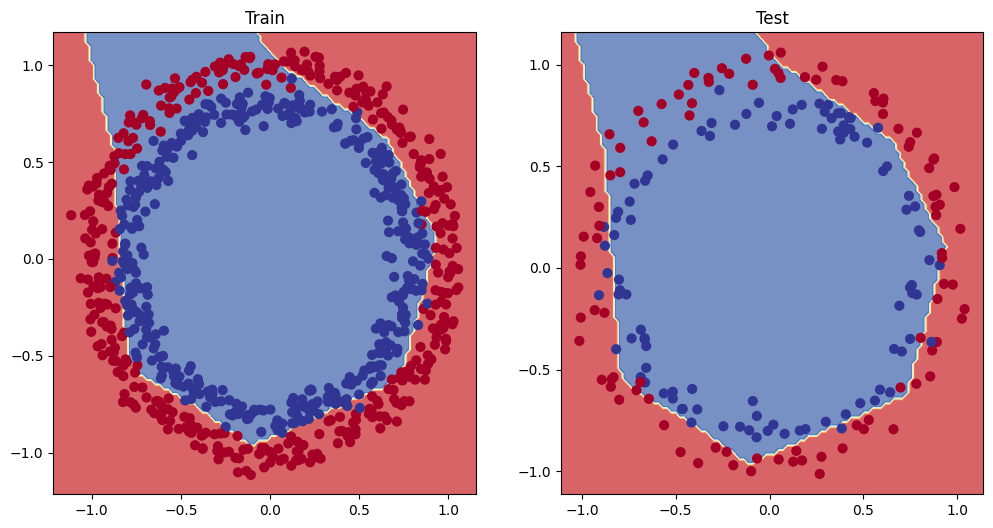

In [41]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns with 1st value is training plot
plt.title('Train')
plot_decision_boundary(model_8, X=X_train, y=y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_8, X=X_test, y=y_test)

plt.show()

### Using the TensorFlow History object to plot a model's loss curves

How did the performance change everytime the model had a chance to look at the data (once every epoch)?

We can check the **loss curves** (also referred to as the **learning curves**) from variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

In [42]:
# see this fit history by transfering it to a DataFrame
pd.DataFrame(model_8_fit_history.history)

,accuracy,loss
0,0.53500,0.685839
1,0.57375,0.677075
2,0.56625,0.671982
3,0.56875,0.667359
4,0.58250,0.663242
5,0.58375,0.658956
6,0.58375,0.653698
7,0.58625,0.646838
8,0.60625,0.639264
9,0.62625,0.630211


Text(0.5, 1.0, 'Model 8 loss curves')

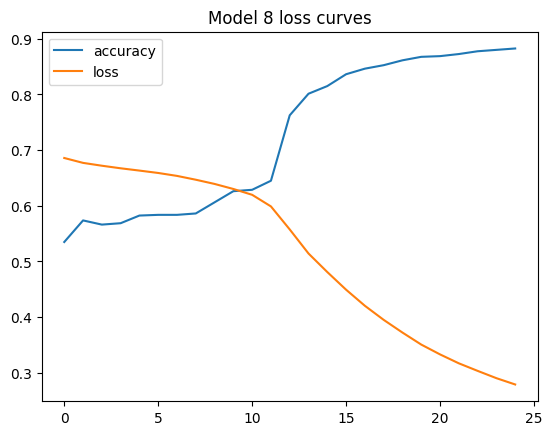

In [43]:
# Plot the los curves
pd.DataFrame(model_8_fit_history.history).plot()
plt.title('Model 8 loss curves')

🔑 Note: For many problems, the loss function going down means the moddel is improving (the predictions it's making are getting closer to the ground truth labels).

### Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the modst important hyperparameter you can tune for neural network models is the learning rate.

In `model_8` we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01`.

And you might be wondering why we did this. Put it this way, it was a lucky guess.

With practice, we will start to see what kind of hyperparameters work and what don't.

That's an important thing to understand about ML and deep learning in gerneral. I'ts very experimental. You build a model and evaluate it and repeat.

So here's a trick will help you find the optimal learning rate (at least to begin training with) for your models going forward.

We are going to use the following:
- A [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
  - It's a callback as an extra piece of functionality you can add to your model while it's training
- Another model (we can use the same ones as above, we're practicing building models here)
- A modified loss curves plot.

🔑 **Note:** The default hyperparameters of many neural network building blocks in TF are setup in a way which usually work right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam). So it's a good idea to try the default first, then adjust as needed.

In [44]:
# Let's create a new model
# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# 2. Compile the model
model_9.compile(loss='binary_crossentropy',
                optimizer='Adam', # use Adam optimizer with default learning rate (0.001)
                metrics=['accuracy'])

# 3. Create a learning rate scheduler callback
# Traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# 4. Fit the model
model_9_fit_history = model_9.fit(X_train, y_train, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4827 - loss: 0.7021 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4827 - loss: 0.7017 - learning_rate: 1.1220e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4757 - loss: 0.7014 - learning_rate: 1.2589e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4757 - loss: 0.7010 - learning_rate: 1.4125e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4755 - loss: 0.7006 - learning_rate: 1.5849e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4728 - loss: 0.7002 - learning_rate: 1.7783e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4740 - loss: 0.6997 - learning_rate: 1.9953e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4756 - loss: 0.6993 - learning_rate: 2.2387e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4809 - loss: 0.6988 - learning_

<Axes: >

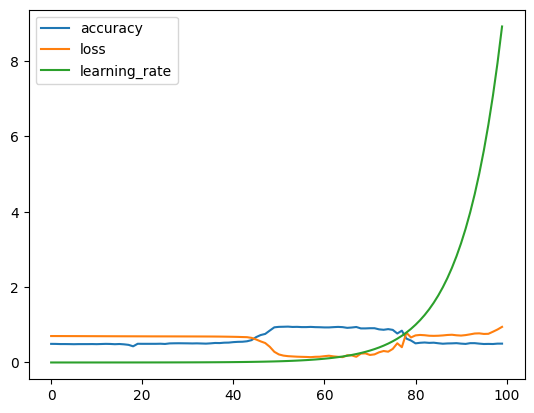

In [45]:
# Checkout the history
pd.DataFrame(model_9_fit_history.history).plot()

As you can see the learning rate exponentially increases as the number of epochs increases.

And the model's accuracy goes up (and loss goes down) at a specific point when the learning rate slowly increases.

To figure out where this infliction point is, we can plot the loss versus the log-scale learning rate

Text(0.5, 1.0, 'Learning rate vs. Loss')

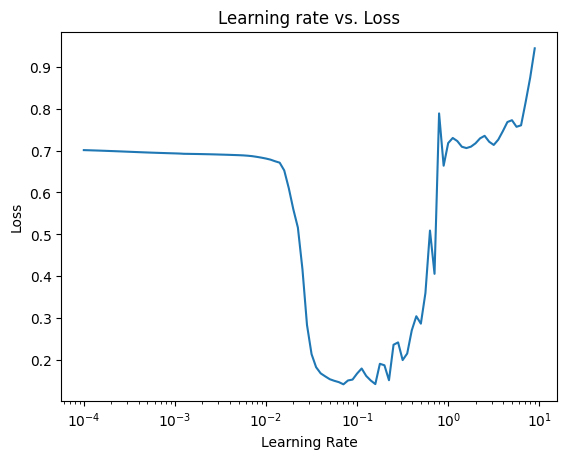

In [46]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20)) # 100 epochs, same formular as the learning rate scheduler
plt.semilogx(lrs, model_9_fit_history.history['loss']) # plot the learning rate to be logarithmic scale on x-axis
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning rate vs. Loss')

To figure out the ideal value of the learning rate (at least the ideal value to begin training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).*

In [47]:
# Examples of other typical learning rate values
10**0, 10**-1, 10**-2, 10**-3, 10**-4 # 10**-4 equals `1e-4`

(1, 0.1, 0.01, 0.001, 0.0001)

### Training and evaluating a model with an ideal learning rate

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it.

In [48]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model
model_10 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 2. Compile the model
model_10.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # set the learning rate to 0.02
                 metrics=['accuracy'])

# 3. Fit the model
model_10_fit_history = model_10.fit(X_train, y_train, epochs=20) # train for 20 epochs (5 less than before)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5599 - loss: 0.6853 
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5659 - loss: 0.6715
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6276 - loss: 0.6469
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6778 - loss: 0.6088
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7707 - loss: 0.5477
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8171 - loss: 0.4974
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.4729
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8353 - loss: 0.4325
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8660 - loss: 0.3920
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8806 - loss: 0.3639
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9199 - loss: 0.2723
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9486 - l

In [49]:
# Evaluate the model
model_10.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9458 - loss: 0.1819


[0.19440408051013947, 0.9350000023841858]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classification...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classification...


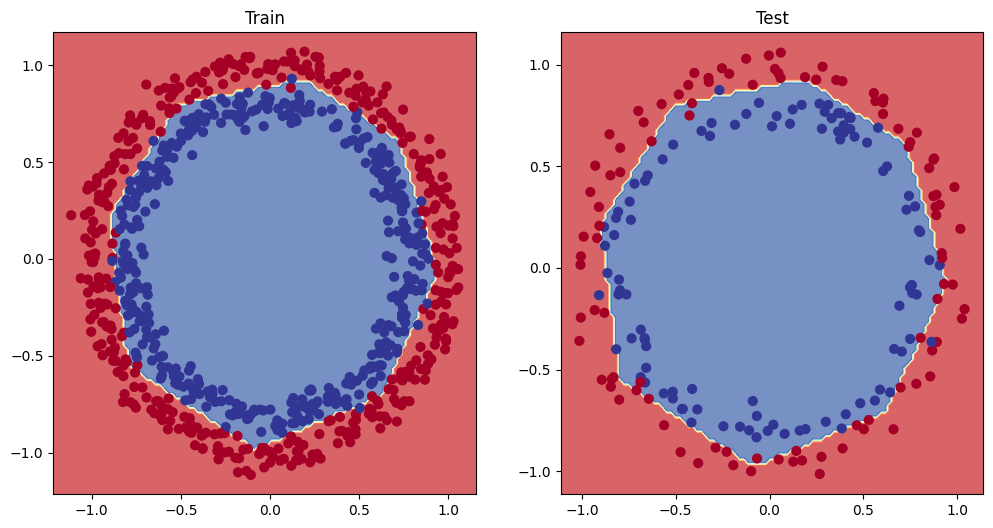

In [50]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_10, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_10, X=X_test, y=y_test)
plt.show()

The accuracy of model_10 is slightly lower than model_8, training longer will improve it.

### More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

> 🔑 **Note:** Every classification problem will require different kinds of evaluation methods. But you should be familiar with at least the ones above.

#### Evaluate accuracy and loss

Let's start with accuracy.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.

In [51]:
# Check the loss and accuracy of the model
loss, accuracy = model_10.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9458 - loss: 0.1819 
Model loss on the test set: 0.19440408051013947
Model accuracy on the test set: 93.50%


#### Confusion matrix

In [52]:
# Make predictions
model_10_preds = model_10.predict(X_test)

# Check the first 10 predictions
model_10_preds[:10]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[9.6121371e-01],
       [1.6453731e-01],
       [9.6121371e-01],
       [6.2822242e-04],
       [5.8522958e-01],
       [7.0842022e-01],
       [9.3883544e-04],
       [2.0655812e-04],
       [9.6121371e-01],
       [4.6301562e-02]], dtype=float32)

In [53]:
# Check the first 10 labels
y_test[:10]

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

It looks like we need to get our predictions into the binary format (0 or 1).

But you might be wondering, what format are they currently in?

In their current format (`9.8526537e-01`), they're in a form called **prediction probabilities**.

You'll see this often with the outputs of neural networks. Often they won't be exact values but more a probability of how *likely* they are to be one value or another.

So one of the steps you'll often see after making predicitons with a neural network is converting the prediction probabilities into labels.

In our case, since our ground truth labels (`y_test`) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [54]:
# Convert the predictions to binary and view the first 10
model_10_preds = tf.round(model_10_preds)

model_10_preds[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [55]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix


# Create confusion matrix
model_10_cm = confusion_matrix(y_test, tf.round(model_10_preds))

# View the confusion matrix
model_10_cm

array([[91,  9],
       [ 4, 96]])

#### Plotting our confusion matrix

##### Plotting confusion matrix by following the course

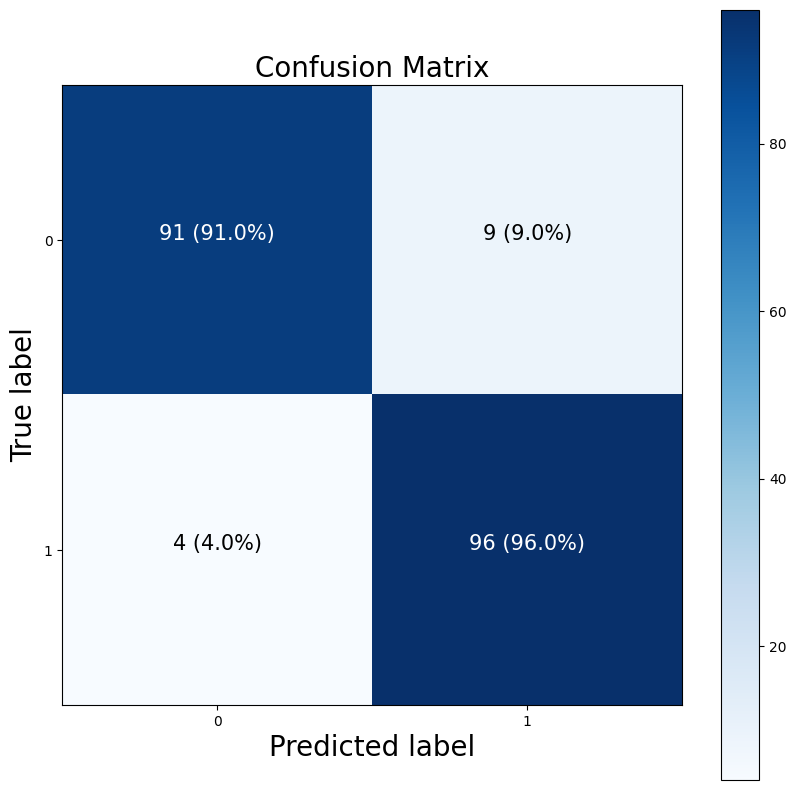

In [56]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools

figsize = (10, 10)

# Create the confusion matrix
cm_norm = model_10_cm.astype("float") / model_10_cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = model_10_cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(model_10_cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(model_10_cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (model_10_cm.max() + model_10_cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(model_10_cm.shape[0]), range(model_10_cm.shape[1])):
  plt.text(j, i, f"{model_10_cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if model_10_cm[i, j] > threshold else "black",
           size=15)

##### Turning the plotting confusion matrix to a function

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), normalize=False):
    """
    Plots a confusion matrix using Matplotlib.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    classes (list): List of class names. If None, integer labels are used.
    figsize (tuple): Size of the figure.
    normalize (bool): Whether to normalize the confusion matrix.
    """
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Set up the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Set up the labels
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels,
           yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm[i, j]*100:.1f}%)" if normalize else f"{cm[i, j]}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=15)

    plt.show()

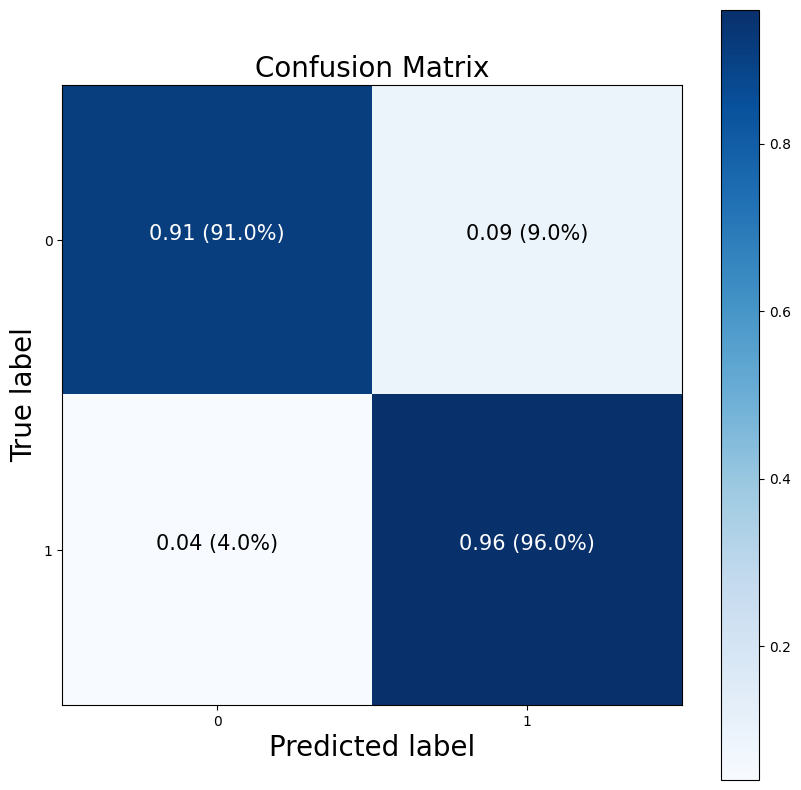

In [58]:
plot_confusion_matrix(y_test, tf.round(model_10_preds), classes=['0', '1'], normalize=True)

## Working with a larger example (multiclass classification)

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as **multiclass classification**.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

Let's see it in action.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as [Fashion MNIST built-in](https://github.com/zalandoresearch/fashion-mnist). Meaning we can get started straight away.

We can import it using the [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) module.

> 📖 **Resource:** The following multiclass classification problem has been adapted from the [TensorFlow classification guide](https://www.tensorflow.org/tutorials/keras/classification). A good exercise would be to once you've gone through the following example, replicate the TensorFlow guide.

### Getting the Data

In [21]:
import tensorflow as tf

# The data has already been sorted into training and test sets for us
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

### Data Exploration

In [22]:
# Show the shape of the data
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [23]:
# Show the first training example
print(f"Training sample:\n{train_data[0]}\n")
print(f"Training label: {train_labels[0]}")

Training sample:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1  

In [24]:
# Check the shape of a single example
train_data[0].shape, train_labels[0].shape

((28, 28), ())

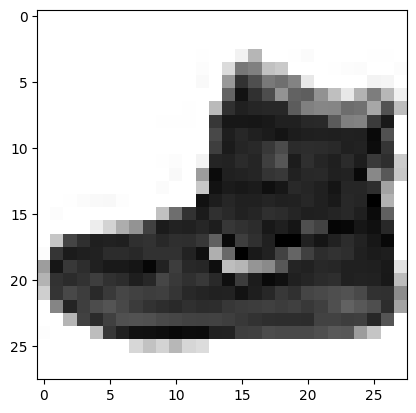

In [25]:
# Plot a single sample
import matplotlib.pyplot as plt
plt.imshow(train_data[0], cmap=plt.cm.binary)

In [26]:
# Create a small list so we can index onto our training labels so they're human-readable
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

len(class_names)

10

Text(0.5, 1.0, 'T-shirt/top')

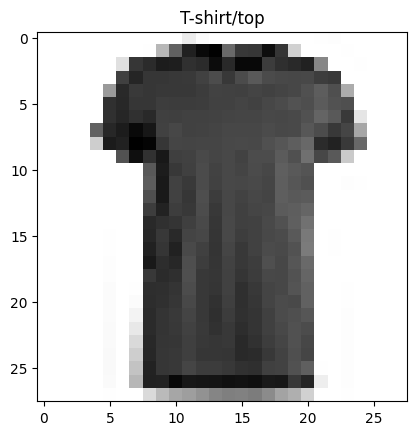

In [27]:
# Plot an example image and it's  label
index_of_choice = 17
plt.imshow(train_data[index_of_choice], cmap=plt.cm.binary)
plt.title(class_names[train_labels[index_of_choice]])

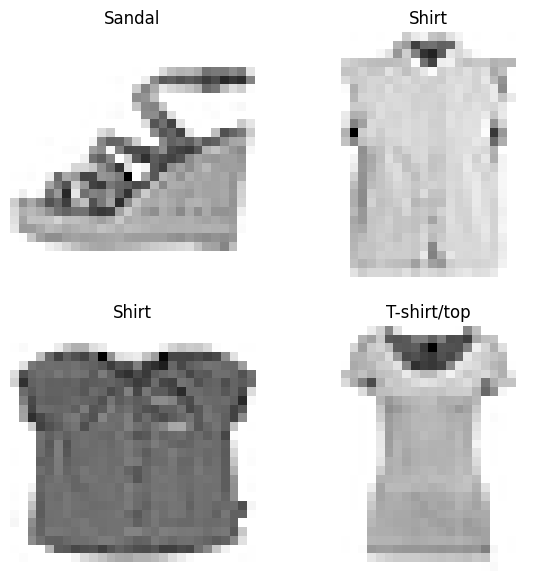

In [28]:
# Plot multiple random images of fashion MNIST
import random

plt.figure(figsize=(7, 7))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    rand_index = random.choice(range(len(train_data)))
    plt.imshow(train_data[rand_index], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[rand_index]])
    plt.axis(False)

### Building our first multi-class classification model

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture (inline with Table 1 above):

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function.
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.

In [29]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_11 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to flatten our 28x28x1 data to 784x1)
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

# Compile the model
# different loss function for multiclass classifcation:
# CategoricalCrossentropy for one-hot endcoded labels
# SparseCategoricalCrossentropy for integer labels
model_11.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

# Fit the model
model_11_fit_history = model_11.fit(
    train_data,
    train_labels,
    epochs=10,
    validation_data=(test_data, test_labels))

Epoch 1/10


/mnt/d/Dev-Workspace/Python-workspace/tensorflow/venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0988 - loss: 2.6804 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0985 - loss: 2.3027 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0986 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0986 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0985 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0985 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0985 - loss: 2.3028 - val_accuracy: 0.1000 - val_loss: 2.3027
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0985 - loss: 2.3028 - val_accurac

### Check the model summary

In [30]:
model_11.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │         3,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,632 (37.63 KB)

 Trainable params: 3,210 (12.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,422 (25.09 KB)

Alright, our model gets to about ~35% accuracy after 10 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy) but we can do better.

Do you remember when we talked about neural networks preferring numbers between 0 and 1?

Well, right now, the data we have isn't between 0 and 1, in other words, it's not normalized. It's pixel values are between 0 and 255.

Let's see.

### Check the min and max values of the training data

In [31]:
train_data.min(), train_data.max()

(0, 255)

### Data scaling (normalization)

We can get these values between 0 and 1 by dividing the entire array by the maximum: `255.0` (dividing by a float also converts to a float).

Doing so will result in all of our data being between 0 and 1 (known as **scaling** or **normalization**).

In [32]:
# Divide train and test images by the maxium value (normalize it)
train_data_norm = train_data / 255.0
test_data_norm = test_data / 255.0

# Check the min and max values of the normalized train data
train_data_norm.min(), train_data_norm.max()

(0.0, 1.0)

### Building our 2nd multi-class classification model using normalized data

In [33]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model_12 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), # input layer (we had to flatten our 28x28x1 data to 784x1)
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

# Compile the model
# different loss function for multiclass classifcation:
# CategoricalCrossentropy for one-hot endcoded labels
# SparseCategoricalCrossentropy for integer labels
model_12.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

# Fit the model
model_12_fit_history = model_12.fit(
    train_data_norm,
    train_labels,
    epochs=10,
    validation_data=(test_data_norm, test_labels))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2268 - loss: 1.9050 - val_accuracy: 0.5678 - val_loss: 1.0576
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5893 - loss: 1.0215 - val_accuracy: 0.6642 - val_loss: 0.9324
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6723 - loss: 0.9001 - val_accuracy: 0.6891 - val_loss: 0.8546
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6905 - loss: 0.8342 - val_accuracy: 0.7004 - val_loss: 0.8225
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7002 - loss: 0.8037 - val_accuracy: 0.7043 - val_loss: 0.8048
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7067 - loss: 0.7865 - val_accuracy: 0.7075 - val_loss: 0.7942
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7111 - loss: 0.7750 - val_accuracy: 0.7113 - val_loss: 0.7864
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7163 - loss: 0.7667 - 

We used the exact same model as before but with normalized data and now seeing a much higher accuracy value!

> 🔑 **Note:** Neural networks tend to prefer data in numerical form as well as scaled/normalized (numbers between 0 to 1)

#### Plot the history of non-normalized/normalized data

<Axes: title={'center': 'Normalized Data'}>

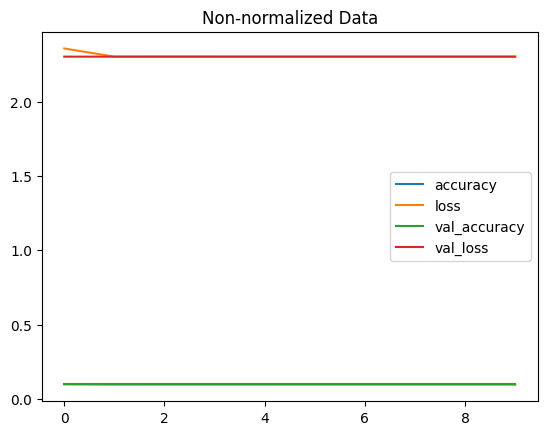

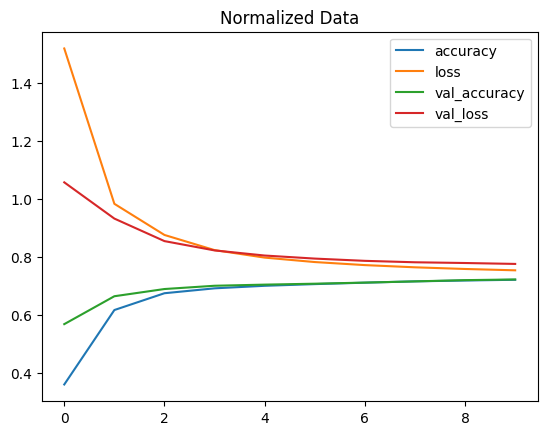

In [34]:
import pandas as pd

# Plot the non-normalized data training history
pd.DataFrame(model_11_fit_history.history).plot(title='Non-normalized Data')

# Plot the normalized data training history
pd.DataFrame(model_12_fit_history.history).plot(title='Normalized Data')

Wow. From these two plots, we can see how much quicker our model with the normalized data (`model_12`) improved than the model with the non-normalized data (`model_11`).

> 🔑 **Note:** The same model with even *slightly* different data can produce *dramatically* different results. So when you're comparing models, it's important to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture).

How about we find the ideal learning rate and see what happens?

We'll use the same architecture we've been using.